In [13]:
import numpy as np
import pandas as pd

import gymnasium as gym

from dicl.main import dicl

import importlib

importlib.reload(dicl)

<module 'dicl.main.dicl' from '/home/abenechehab/dicl/src/dicl/main/dicl.py'>

In [16]:
import torch
from transformers import LlamaForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/5d853ed7d16ac794afa8f5c9c7f59f4e9c950954",
    use_fast=False,
)
print("finish loading tokenizer")
model = LlamaForCausalLM.from_pretrained(
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/5d853ed7d16ac794afa8f5c9c7f59f4e9c950954",
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
print("finish loading model")
model.eval()

finish loading tokenizer


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


finish loading model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

In [17]:
env_name = "HalfCheetah"
env = gym.make(env_name)
n_actions = env.action_space.shape[0]
n_observations = env.observation_space.shape[0]

# load some data to get a pool of states
data_label = "expert"
data_path = f"/home/abenechehab/datasets/{env_name}/{data_label}/X_test.csv"
X = pd.read_csv(data_path, index_col=0)
if "obs_reward" in X.columns:
    X = X.drop(["obs_reward"], axis=1)
X = X.values.astype("float")

# find episodes beginnings
restart_index = n_observations + n_actions  # +1 for halfcheetah
restarts = X[:, restart_index + 1]
episode_starts = np.where(restarts)[0]
episode_starts

/home/abenechehab/miniconda3/envs/DICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:531: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(


array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
        9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
       18000])

In [18]:
context_length = 500
rescale_factor = 7.0
up_shift = 1.5

episode = 16

init_index = episode_starts[episode]

In [19]:
time_series = X[init_index : init_index + context_length, : n_observations + n_actions]

In [20]:
DICL = dicl.DICL_PCA(
    n_components=7,
    model=model,
    tokenizer=tokenizer,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)

In [21]:
DICL.fit_disentangler(X=time_series)
mean, mode, lb, ub = DICL.predict_single_step(X=time_series)

/home/abenechehab/dicl/src/dicl/main/iclearner.py:227: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/dicl/src/dicl/utils/from_liu_et_al.py:335: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/dicl/src/dicl/utils/from_liu_et_al.py:336: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


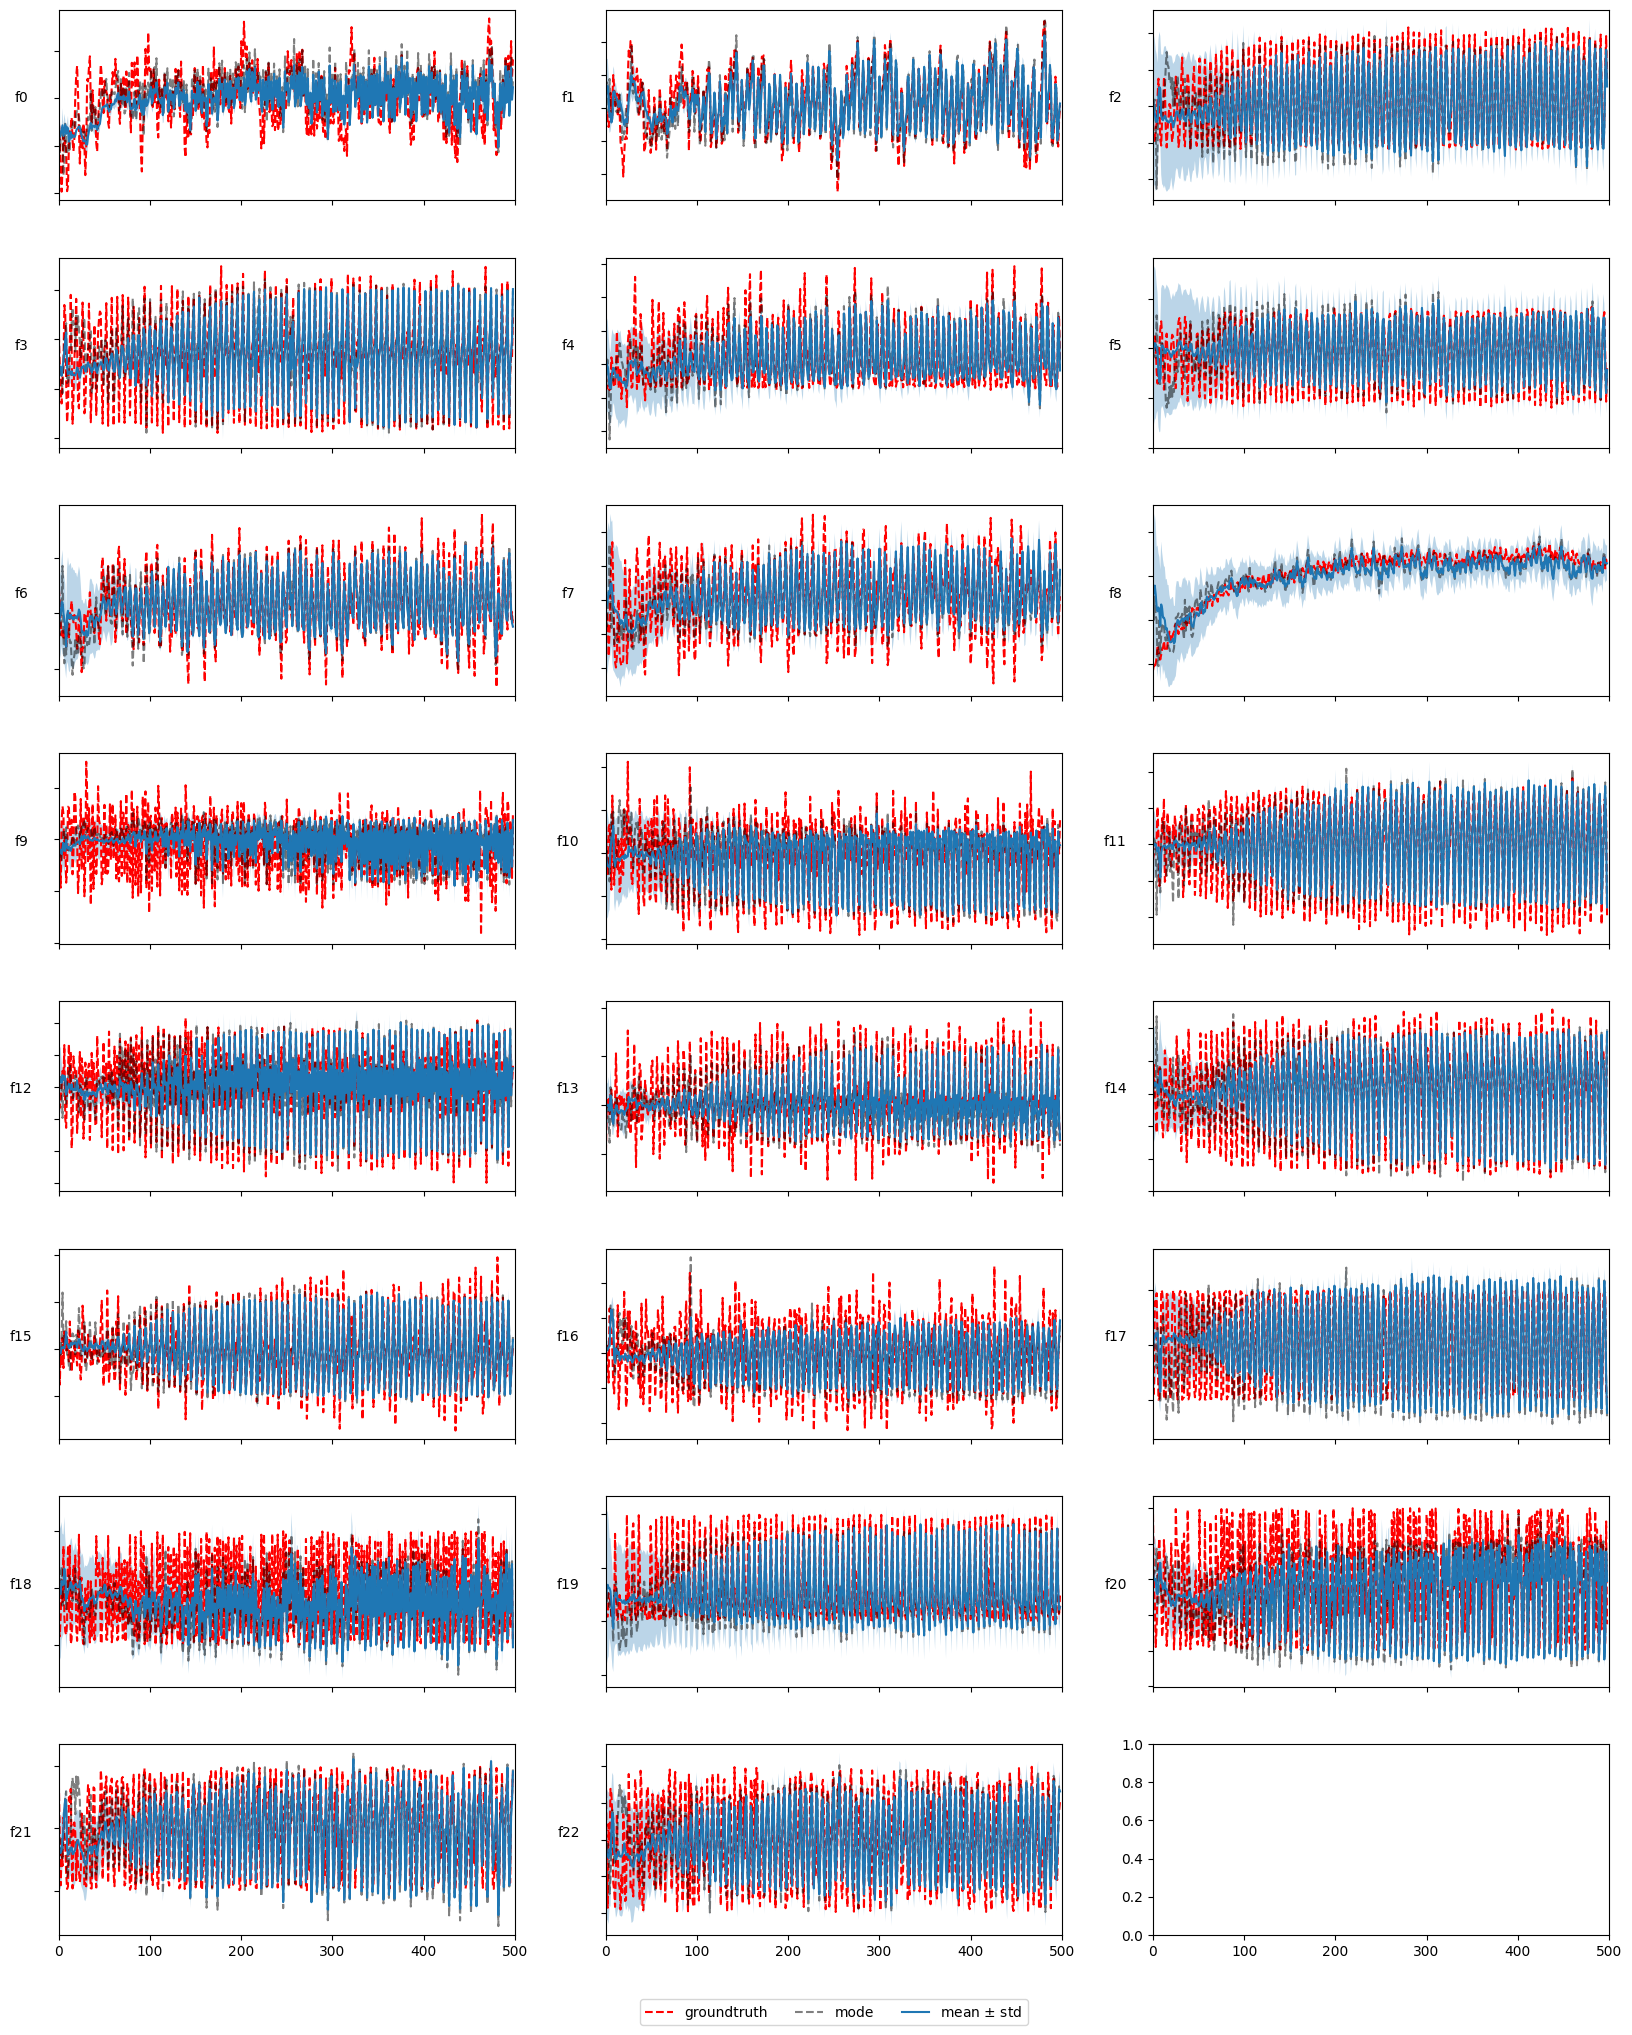

In [23]:
DICL.plot_single_step(xlim=[0, 500])